<a href="https://colab.research.google.com/github/fabio-a-oliveira/ds-sandbox/blob/master/Autoencoder_Renner_FabioOliveira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Introdução

Este _notebook_ trata do problema proposto em desafio para o processo seletivo da Renner e implementa um modelo de _autoencoder_ de séries temporais.

Na seção 2, faço uma discussão sobre o problema e respondo às questões dissertativas apresentadas no desafio. A análise do _dataset_ proposto, preparação dos dados, criação e treinamento do modelo do _autoencoder_ são realizadas na seção 3. A seção 4 apresenta os resultados do processo de treinamento e da reconstrução da série original ao longo do tempo e algumas conclusões são apresentadas na seção 5.

Para facilidade de acesso, o _notebook_ está hospedado no GitHub e pode ser acessado por [este link](https://github.com/fabio-a-oliveira/ds-sandbox/blob/master/Autoencoder_Renner_FabioOliveira.ipynb). Caso queira reproduzir as análises, recomendo abrir o _notebook_ no ambiente do _Google Colab_ através [deste link](https://colab.research.google.com/github/fabio-a-oliveira/ds-sandbox/blob/master/Autoencoder_Renner_FabioOliveira.ipynb) e habilitar o uso de GPU para treinamento do modelo.

# 2 Discussão

Nesta seção, discuto alguns aspectos técnicos da abordagem escolhida e respondo às questões dissertativas propostas no desafio.

## 2.1 Abordagem escolhida

Escolhi implementar uma arquitetura de modelo combinado, baseada na seção 2.4 do _paper_ de referência [Unsupervised Learning of Video Representations using LSTMs](http://www.cs.toronto.edu/~nitish/unsup_video.pdf). Nesta abordagem, aplica-se o conceito de _multitask learning_, em que o modelo é treinado para a realização simultânea de duas tarefas relacionadas, de maneira que seja facilitada a extração de informações e identificação de padrões mais complexos nos dados.

A tarefa primária é a principal, que foi proposta pelo desafio - a reconstrução do sinal de entrada à partir de um vetor de dimensionalidade reduzida. A segunda tarefa tem caráter auxiliar, e foi formulada para que trouxesse benefícios em performance à anterior - trata-se da extrapolação da sequência de entrada, prevendo o valor das próximas observações na sequência.

O _encoding_ foi feito através de uma _stack_ de duas LSTMs. A primeira camada é bidirecional, avaliando a sequência de entrada nos dois sentidos. A segunda é uma camada LSTM convencional, cuja saída alimenta uma camada densamente conectada de dimensão igual à dimensão selecionada para o _encoding_.

O _decoder_ foi implementado com uma _stack_ de duas LSTMs bidirecionais, conectadas a uma camada _Dense_ distribuída no tempo. Aqui, ambas as camadas podem ser bidirecionais, já que é gerada saída a cada passo. 

Diferente do que foi feito no _paper_ de referência, preferi conectar a saída do _encoder_ às entradas das LSTMs do _decoder_, ao invés de seu vetor de estado. Esta escolha gerou dois benefícios: 1) a representação vetorial da sequência de entrada é fornecida às LSTMs uniformemente a cada passo, liberando seus vetores de estado para propagarem qualquer outra informação revelada importante durante o treinamento e 2) pude escolher livremente a quantidade de unidades das LSTMs do _decoder_ independentemente da dimensionalidade da representação. Por outro lado, essa escolha impossibilitou a aplicação do que o _paper_ chama de _conditional decoder_, em que a saída gerada pelo _decoder_ a cada passo é fornecida como entrada no passo seguinte.

A exemplo do que foi feito no _paper_, inverti a ordem da sequência para sua reconstrução. Isso permite que a dificuldade da tarefa de reconstrução aumente mais gradativamente durante o processo de treinamento, já que a última amostra da sequência (logo antes do _encoder_) é também a primeira a ser reconstruída (logo após o _encoder_).

Para a tarefa de predição das amostras seguintes, escolhi um período de 3 amostras no futuro. Testei valores diferentes e este foi o que possibilitou a melhor performance na tarefa primária. Além disso, reduzi a 20% o peso que esta tarefa teve no cálculo da _loss function_ total utilizada para otimização do modelo (distribuição 100% para tarefa principal e 20% para a secundária). Dessa forma, foi mitigada a séria tendência a _overfitting_ nesta tarefa quando o modelo era treinado com pesos iguais para ambas.

Além disso, as sequências foram pré-processadas com aplicação de $log_{10}$ e _scaling_. A escala logarítmica é mais adequada quando os dados tem característica que ocupa várias ordens de grandeza. Ela também preserva as relações percentuais no cálculo dos métricas.

Após o pré-processamento, foi aplicada uma camada de ruído Gaussiano ao sinal de entrada. O ruído, gerado aleatoriamente a cada _batch_ de dados, provê efeito de regularização, reduz _overfitting_, e serve como _augmentation_ artificial dos dados.

Como estratégia de validação, dividi o _dataset_ fornecido de acordo com o ano das observações: fiz o treinamento com os dados de 2018 e validação com dados de 2019 (ambos os anos com perfis bastante parecidos). Usei os dados de 2020 como conjunto de testes. À rigor, os dados de validação e testes deveriam vir da mesma distribuição, e o conjunto de treinamento deveria ter um percentual maior dos dados. Entretanto, achei que essa distribuição teria vantagens, já que permitiu que tanto treinamento quanto validação tivessem um ciclo anual completo, e permitiu também avaliar a performance do modelo em um ano com dados não somente inéditos, mas também de natureza bastante diferente do treinamento (2020 parece ter sido rigorosamente afetado pela pandemia).

Escolhi treinar o _autoencoder_ para elaborar um _encoding_ de 15 dimensões. Me pareceu um compromisso razoável entre a dificuldade da tarefa (já que são metade das dimensões da sequência original) e a capacidade de reconstrução.

## 2.2 Respostas às questões dissertativas

* ___Quais métricas você usou para avaliar o desempenho da solução?___

Usei o _mean squared error_ (MSE) como _loss function_ para o treinamento e avaliação do desempenho do modelo. É a métrica mais convencional para problemas de regressão.  

Em algumas ocasiões, especialmente quando se pretende um modelo que não seja extremamente sensível a _outliers_, é comum utilizar o _mean absolute error_ (MAE) ou a _Huber loss_ como métricas. Entretanto, os dados fornecidos tem uma caraterística cíclica muito distinta, com picos de vendas especialmente aos sábados. Preferi utilizar o MSE para que o modelo fosse estimulado a capturar este padrão durante o treinamento.

Vale chamar a atenção ao fato de que os dados foram transformados antes de serem processados pelo modelo (foi calculado o $log_{10}$ e os valores foram escalados para que o conjunto de treinamento ficasse no intervalo [-0.5,0.5]). Por se tratar de um problema _self-supervised_, os valores dos labels também foram igualmente processados. Assim, o valor obtido pelo cálculo do MSE não guarda relação intuitiva com a precisão na escala original dos dados.

Além disso, os modelo de treinamento e inferência não são exatamente iguais. Durante o treinamento, usei um modelo combinado, cujas saídas são ambas a reconstrução do sinal original e a previsão das próximas amostras (vide seção 2.4 do _paper_ de referência). A _loss function_ minimizada durante o treinamento foi uma combinação linear do MSE medido para cada uma das saídas, com o peso da saída auxiliar ajustado para otimizar o resultado na tarefa principal de reconstrução e ao mesmo tempo reduzir o _overfitting_ na tarefa de predição. Para inferência, usa-se um modelo com somente o _decoder_ como saída, sem geração da previsão das próximas amostras.






* ___Qual o método para avaliar o desempenho?___

Conforme mencionado acima, a métrica objetiva utilizada para treinamento do modelo foi o MSE combinado entre as duas saídas produzidas pelo modelo. Para balizar as decisões de arquitetura e o _tuning_ de hiperparâmetros, monitorei o MSE medido somente na tarefa de _decoding_.

Além disso, avaliei as curvas de performance ao longo do treinamento, tentando capturar indícios mais subjetivos que indicassem a saúde do modelo. Ajustei o peso aplicado ao MSE da previsão das próximas amostras, assim como a quantidade de amostras a serem previstas, para reduzir o _overfitting_ nessa tarefa auxiliar. É bastante intuitivo perceber que a tarefa de predição é mais desafiadora do que a de reconstrução, mesmo com a adição de ruído ao sinal de entrada. Assim, combinações de hiper-parâmetros que possibilitassem um desempenho melhor na previsão do que na reconstrução provavelmente estariam permitindo que o modelo aprendesse representações triviais da sequência de entrada.

A decisão de calcular as métricas nos dados transformados (com aplicação de $log_{10}$ e _scaling_) também é relevante na avaliação do desempenho. A escala logarítmica permite observar a razão entre os valores originais (ao invés da simples diferença), o que é importante quando os dados tem característica exponencial e ocupam uma escala com várias ordens de grandeza.

* ___Cite o que poderia ser melhorado na sua solução para gerar melhores resultados, caso o resultado seja ruim.___

Não tenho subsídios para afirmar que o resultado tenha ficado bom ou ruim, já que não foi traçado um objetivo claro sobre o tipo de aplicação do modelo. Como não foi estipulada restrição à dimensionalidade da representação, poderia ter conseguido uma reconstrução arbitrariamente precisa do sinal original simplesmente aumentando esta dimensionalidade.

Escolhi arbitrariamente uma representação em 15 dimensões, e uma avaliação subjetiva do sinal reconstruído para o conjunto de validação mostra uma grande proximidade com o sinal original.

De qualquer maneira, alguns pontos poderiam ter sido implementados para melhorar o nível de performance:

__1. _Tuning_ de hiperparâmetros:__ realizei a escolha dos hiperparâmetros com um pouco de experimentação, mas sem uma abordagem sistemática para otimizar o resultado. Utilizar uma ferramenta como o _keras tuner_ seria uma maneira garantida de investir um pouco de tempo e poder computacional para encontrar parâmetros que gerassem um resultado melhor.

__2. _Decoder_ condicional:__ o _paper_ de referência mostrou uma melhora sutil no desempenho do _decoder_ ao utilizar o valor atribuído em cada passo como entrada da LSTM no passo seguinte. Essa escolha foi possibilitada por uma característica importante de implementação: o vetor de _encoding_ era passado ao _decoder_ através dos vetores de estado da LSTM, ao invés do seu _gate_ de entrada. Na minha implementação, usei a entrada das LSTMs do _decoder_ para passar o vetor __a cada passo__, deixando os vetores de estado livres para o aprendizado mais efetivo e garantindo que a informação do _encoding_ não seria diluída ao longo dos passos do _decoder_. Além disso, minha implementação me deu a liberdade de escolher a quantidade de unidades das LSTMs do _decoder_ separadamente da dimensionalidade do vetor de _encoding_. Tenho a intuição de que, para um problema tão simples quanto a reconstrução de um vetor com poucas amostras, minha implementação é mais adequada. Entretanto, poderia experimentar com a outra implementação e avaliar se a intuição se confirma ou não, ganhando uma melhora de performance caso estivesse enganado.

__3. Dados adicionais no _encoding_:__ acredito que poderia melhorar sutilmente a performance caso acrescentasse mais informações ao vetor de entrada. Poderia, por exemplo, incluir um dado categórico indicando o dia da semana (com _one-hot encoding_ ou até mesmo um booleano indicando somente o sábado). Poderia também incluir um dado categórico indicando o mês (os meses com Natal, dia dos namorados, dia dos pais e dia das mães têm comportamentos diferentes dos demais). Estas informações poderiam ser incluídas sem custo adicional de coleta de dados (já que a data já está presente no _dataset_). Creio que certo ganho de performance poderia advir do acréscimo destas informações, mesmo que não fosse muito grande (por exemplo, o comportamento semanal pode ser aprendido pelo modelo diretamente da sequência de dados, sem precisar de indicação explícita do dia da semana como variável adicional). Entretanto, seria necessário um volume maior de dados para conseguir experimentar este ganho: por exemplo, ao adicionar dado categórico indicando o mês do ano, o modelo seria treinado com somente uma sequência completa de cada mês (fiz este teste, o modelo não foi capaz de aprender as características específicas da época do Natal tendo tão poucos exemplos).

__4. Pré-treinamento:__ a aplicação de pré-treinamento do modelo em tarefa semelhante é uma prática que, na maioria das vezes, melhora a performance final. Para isso, poderia fazer o pré-treinamento do modelo com qualquer _dataset_ contendo uma sequência temporal, sujeito a um condicionamento dos dados para deixá-los em escala similar. Poderia até inserir artificialmente nos dados alguns dos fenômenos observados no _dataset_ fornecido, como a característica cíclica semanal.

* ___Na sua opinião, existe alguma problemática de negócio ou técnica que poderia ser aplicado este AutoEncoder? Se sim, descreva essa problemática.___

_Autoencoders_ têm algumas aplicações clássicas. Abaixo, discuto um pouco o potencial do uso deste modelo em particular para algumas delas:

__1. Compressão dos dados:__ _autoencoders_ podem ser usados para reduzir a dimensionalidade dos dados, possibilitando seu armazenamento mais eficaz. Uma aplicação similar é a extração de _features_ para aplicação de outro modelo de _machine learning_ como próximo passo no _pipeline_. Para ambos os casos, não acredito que esta seja uma aplicação viável, já que os dados fornecidos já são de uma dimensionalidade bastante baixa. Como comparação, o _paper_ de referência aplica arquitetura parecida para a reconstrução e extrapolação de arquivos de vídeo, que são tensores com 4 dimensões (_frame_, altura, largura e canal). Nesta situação, há um potencial gigantesco para compressão com base na continuidade entre o conteúdo dos diferentes canais - subsequentes colunas e linhas de cada imagem são altamente correlacionadas, assim como _frames_ subsequentes tem alta correlação. Por outro lado, o _dataset_ fornecido no desafio é um tensor de baixa dimensionalidade, com dados escalares únicos a cada amostra. Assim, creio que uma abordagem muito mais eficaz para compressão seria a aplicação de alguma transformação explícita (e.g. mínimo, máximo e total, que são valores altamente informativos porém cujo aprendizado não é trivial para redes neurais). Entretanto, acredito que poderia haver aplicação caso o problema fosse ligeiramente modificado: se os dados de entrada contivessem amostras de vendas de __múltiplas lojas__ em paralelo, a aplicação de um _autoencoder_ poderia sim comprimir adequadamente os dados e/ou processá-los para aplicação em modelo de ML.

__2. Identificação de anomalias:__ esta é uma aplicação bastante plausível, que poderia ser feita com este modelo e o mesmo perfil de dados. O funcionamento do par _encoder_/_decoder_ depende da identificação por ambos de padrões subjacentes nos dados. O _encoding_ por PCA/SVD depende da compreensão compartilhada de que as dimensões ignoradas contém variância desprezível. O _encoding_ por .MP3 depende da compreensão de que há menos informação relevante em determinadas frequências. A representação de matrizes esparsas depende do entendimento compartilhado de que termos não representados são nulos. A comunicação por linguagem depende de uma compreensão compartilhada sobre o mundo (em NLU refere-se a este aspecto como _missing text phenomenom_ - MTP). Assim, quando estes padrões subjacentes deixam de ser válidos, o erro de reconstrução do sinal original vai invariavelmente aumentar. Com isso em mente, separei o _dataset_ nos conjuntos de treinamento (2018), validação (2019) e testes (2020). Como era de se esperar, o erro de reconstrução do modelo quando aplicado nos dados de 2020 é muito maior do que no ano anterior, já que o comportamento foi drasticamente alterado devido à situação de pandemia e aos diversos _lock-downs_ ao longo do ano. Dessa forma, um modelo de _autoencoder_ como este pode ser utilizado para identificar discrepâncias em lojas da cadeia (as vendas podem estar se comportando diferentemente do padrão por causa de algum problema estrutural ou porque alguma ação foi muito bem sucedida e pode ser replicada nas demais lojas) ou até para determinados produtos (que podem estar vendendo em ritmo diferente do padrão, e cuja causa pode ser identificada para correção ou para maximizar o aproveitamento).

# 3 Modelo

Nesta seção, faço a preparação e análise dos dados, assim como a elaboração e treinamento do modelo do _autoencoder_.

## 3.1 Setup e preparação do dataset

Aqui, faço o _import_ das bibliotecas utilizadas e do _dataset_. Para que o _notebook_ possa ser rodado com menor dependência do ambiente e da disposição dos dados, carreguei o arquivo em um _bucket_ S3 na AWS.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, LSTM, Bidirectional, Dense, RepeatVector, TimeDistributed, GaussianNoise, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import datetime

Abaixo, carrego o _dataset_ como _dataframe_ do Pandas e faço primeira inspeção do conteúdo.

In [2]:
DATASET_URL = "https://renner-autoencoder.s3.amazonaws.com/dados.tsv"
ds = pd.read_csv(DATASET_URL, sep='\t')
ds

,sales_day,venda
0,2018-01-02,763.7255
1,2018-01-03,829.9450
2,2018-01-04,899.3964
3,2018-01-05,1052.9464
4,2018-01-06,1288.6908
...,...,...
924,2020-11-01,626.7448
925,2020-11-02,466.5640
926,2020-11-03,529.6039
927,2020-11-04,808.4397


A classe a seguir implementa a transformação aplicada ao dados. Segui uma interface similar ao _scikit-learn_, com métodos `fit` e `transform`, mas preferi criar uma classe específica para incluir também o método `inverse_transform`.

Preferi fazer o _scaling_ MinMax para o intervalo [-0.5, 0.5]. Assim, posso usar ativação _tanh_ nas saídas do modelo, garantindo que os valores ficarão restritos ao intervalo [-1,1], ao mesmo tempo permitindo que saiam do intervalo observado no conjunto de treinamento. O modo de _scaling_ para distribuição normal padrão foi incluído na classe, mas não apresentou resultados tão bons e não o utilizei no modelo.

In [3]:
class Scaling():
    """
    Implementa dois métodos de scaling, de acordo com argumento 'mode':
    - 'minmax': log10 -> scaling para intervalo [-.5, .5]
    - 'normal': log10 -> scaling para normal padrão
    """
    
    def __init__(self, mode='minmax'):
        if mode == 'minmax':
            self.mode = 'minmax'
        elif mode == 'normal':
            self.mode = 'normal'
        else:
            raise NotImplementedError("Argumento 'mode' deve ser 'normal' ou 'minmax'")
        self.built = False

    def fit(self, array):
        import numpy as np
        if self.mode == 'minmax':
            self.min = np.min(array)
            self.max = np.max(array)
            self.built = True
        elif self.mode == 'normal':
            log_array = np.log10(array)
            self.mean = log_array.mean()
            self.std = log_array.std()
            self.built = True

    def transform(self, array):
        import numpy as np
        if self.built:
            if self.mode == 'normal':
                return (np.log10(array) - self.mean) / self.std
            elif self.mode == 'minmax':
                return (array - self.min) / (self.max - self.min) - .5
        else:
            raise Exception('Chame o método fit() antes de utilizar transform()')

    def inverse_transform(self, array):
        if self.built:
            if self.mode == 'normal':
                return 10 ** (array * self.std + self.mean)
            elif self.mode == 'minmax':
                return (array + .5) * (self.max - self.min) + self.min
        else:
            raise Exception('Chame o método fit() antes de utilizar inverse_transform()')

A função a seguir recebe um dataframe no formato carregado do _dataset_ e retorna objetos `tf.data.Dataset` prontos para o treinamento do modelo. O pré-processamento (aplicação de $log_{10}$ e _scaling_) também é aplicado pela função.

In [4]:
def prepare_dataset(dataset, mode='composite', seq_length=30, batch_size=32, prediction_length=7, scaling_obj=None):
    """"
    Recebe dataframe no formato do dataset fornecido e retorna objeto da classe
    tf.data.Dataset, com shuffling das observações e em batches
    """

    dataframe = dataset.copy()

    # transformação padrão, coloca aproximadamente no intervalo [-1, 1]
    if scaling_obj == None: 
        dataframe.venda = np.log10(dataframe.venda) * .4 - .6
        dataset_array = dataframe.venda.values.reshape(-1,1)

    # transformação informada na chamada da função
    else: 
        dataset_array = scaling_obj.transform(dataframe.venda.values).reshape(-1,1)

        # provisões para adicionar one-hot-encoding do mês ao array
        #month = tf.one_hot(dataframe.sales_day.map(lambda date: int(date.split('-')[1])-1), depth=12).numpy().reshape(-1, 12)
        #dataset_array = np.concatenate((dataset_array, month[:,[11]]), axis=1) # somente one-hot de dezembro


    # modo composto, com 2 tasks
    if mode == 'composite':

        # obter sequências de cumprimento seq_length + prediction_length
        sequence = [dataset_array[row-seq_length-prediction_length:row, :] for row in range(seq_length+prediction_length, dataset_array.shape[0])]
        sequence = np.array(sequence)

        # obter arrays correspondendo aos dados de entrada do encoder e targets
        # do decoder do do predictor
        x = sequence[:, :seq_length, :]
        y_reconstruct = x[:, ::-1, [0]]
        y_predict = sequence[:, seq_length:, [0]]

        # transformação em objetos tf.data.Dataset
        ds_x = tf.data.Dataset.from_tensor_slices(x)
        ds_yr = tf.data.Dataset.from_tensor_slices(y_reconstruct)
        ds_yp = tf.data.Dataset.from_tensor_slices(y_predict)

        # junção dos datasets em objeto único, cache, shuffling, batching
        ds_y = tf.data.Dataset.zip((ds_yr, ds_yp))
        ds_xy = tf.data.Dataset.zip((ds_x, ds_y)).cache().shuffle(1000).batch(batch_size).prefetch(1)
        
        return ds_xy

    # provisão para geração de dataset somente para o autoencoder
    else: 
        raise NotImplementedError("invalid mode argument")

Abaixo, pode-se inspecionar a dimensionalidade do objeto retornado pela função. Com os valores padrão, tem-se sequências de entrada com 30 observações de dimensão 1, e como saída uma sequência invertida com mesmas dimensões e uma sequência de 7 dias para a tarefa de extrapolação.

In [5]:
prepare_dataset(ds)

<PrefetchDataset shapes: ((None, 30, 1), ((None, 30, 1), (None, 7, 1))), types: (tf.float64, (tf.float64, tf.float64))>

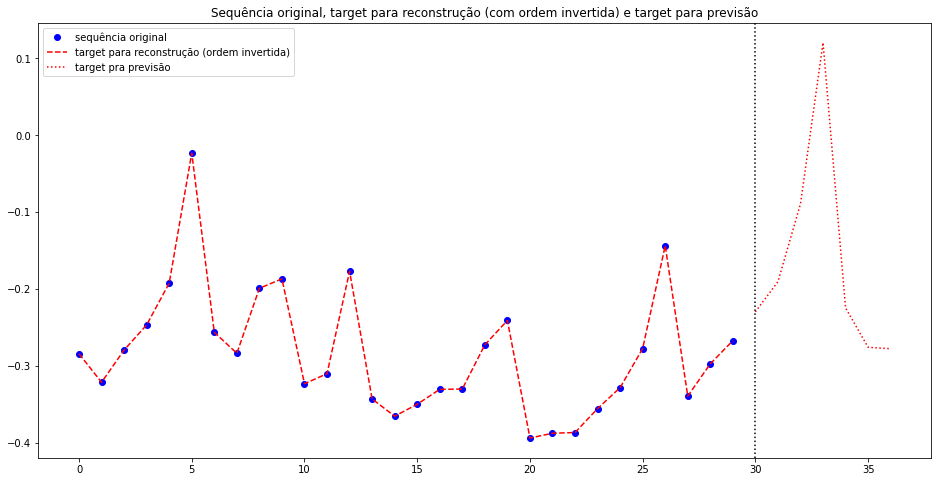

In [6]:
scaler = Scaling()
scaler.fit(ds.venda.values)

sample = prepare_dataset(ds, mode='composite', seq_length=30, prediction_length=7, scaling_obj=scaler)
x, y = sample.take(1).as_numpy_iterator().next()
yr, yp = y

plt.figure(figsize=(16,8))
plt.title('Sequência original, target para reconstrução (com ordem invertida) e target para previsão')
plt.plot(range(30), x[0,:,0], 'bo', label='sequência original');
plt.plot(range(30), yr[0,::-1,0], 'r', linestyle='--', label='target para reconstrução (ordem invertida)');
plt.plot(range(30,37), yp[0,:,0], 'r', linestyle=':', label='target pra previsão');
plt.axvline(30, c='black',linestyle=':');
plt.legend(loc='upper left');

## 3.2 Análise exploratória de dados

A seguir, faço uma breve exploração dos dados providos no _dataset_.

In [7]:
ds

,sales_day,venda
0,2018-01-02,763.7255
1,2018-01-03,829.9450
2,2018-01-04,899.3964
3,2018-01-05,1052.9464
4,2018-01-06,1288.6908
...,...,...
924,2020-11-01,626.7448
925,2020-11-02,466.5640
926,2020-11-03,529.6039
927,2020-11-04,808.4397


In [8]:
ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
venda,929.0,1111.533447,623.757588,0.2322,777.6756,932.0274,1246.1921,5299.721


A visualização abaixo é bastante informativa. Os menores valores estão todos no ano de 2020, comportamento diretamento ligado à pandemia. O comportamento da sequência também é visivelmente diferente.

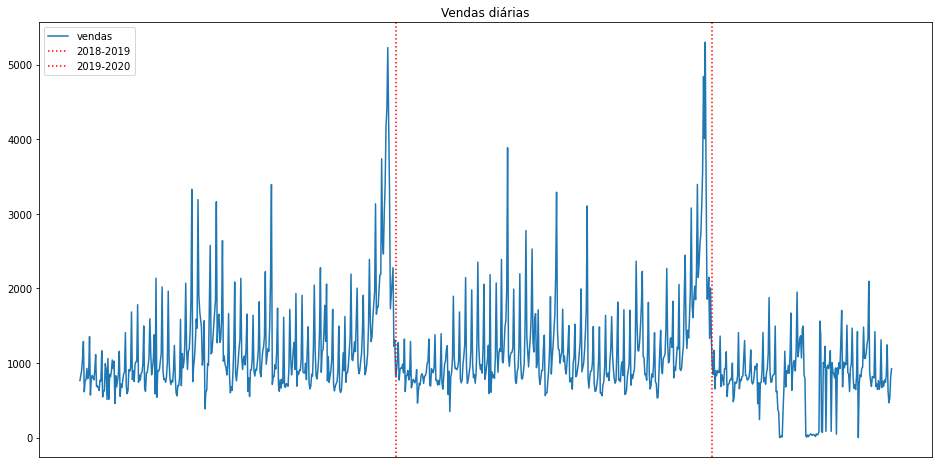

In [9]:
plt.figure(figsize=(16,8))
plt.title('Vendas diárias')
plt.plot(ds.sales_day, ds.venda, label='vendas');
plt.xticks([])
plt.axvline('2019-01-02', c='r', linestyle=':', label='2018-2019');
plt.axvline('2020-01-02', c='r', linestyle=':', label='2019-2020');
plt.legend(loc='upper left');

A visualização abaixo mostra histogramas dos valores diários de vendas, com e sem aplicação de $log_{10}$ e incluindo ou não o ano de 2020. O gráfico no canto inferior direito mostra que, ao aplicar o logaritmo e remover os dados de 2020, temos uma incidência de valores mais reminiscente de uma distribuição normal.

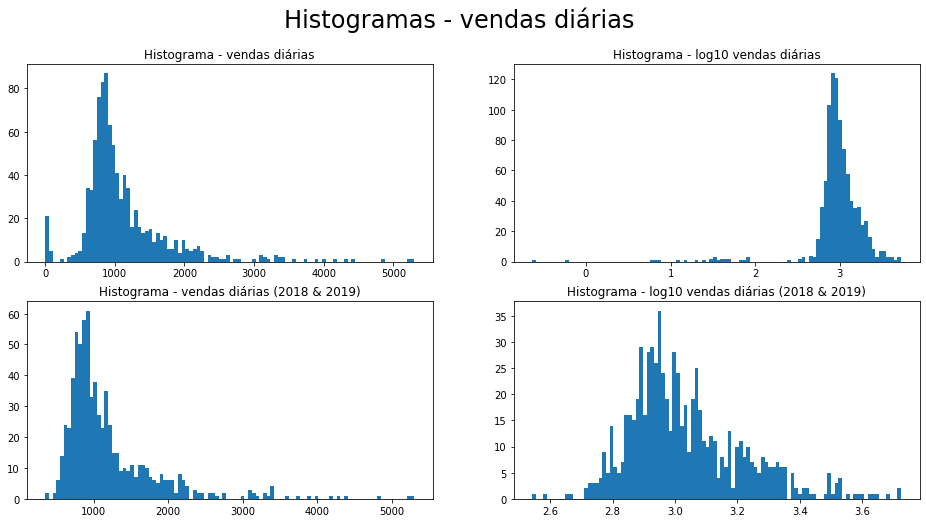

In [10]:
plt.figure(figsize=(16,8))
plt.suptitle('Histogramas - vendas diárias', fontsize=24)

plt.subplot(2,2,1)
plt.title('Histograma - vendas diárias')
plt.hist(ds.venda, bins=100);

plt.subplot(2,2,2)
plt.title('Histograma - log10 vendas diárias')
plt.hist(np.log10(ds.venda), bins=100);

plt.subplot(2,2,3)
plt.title('Histograma - vendas diárias (2018 & 2019)')
plt.hist(ds.venda[ds.sales_day < '2020'], bins=100);

plt.subplot(2,2,4)
plt.title('Histograma - log10 vendas diárias (2018 & 2019)')
plt.hist(np.log10(ds.venda[ds.sales_day < '2020']), bins=100);

A figura abaixo mostra as médias de vendas diárias para os mesmos dias dos anos de 2018 e 2019. Por haver somente dois anos, as curvas ficam bastante ruidosas (o efeito cíclico semanal seria amenizado com uma quantidade maior de anos). Porém, é possível reconhecer que os meses de maio, junho, agosto e dezembro (dias dos namorados, das mães, dos pais e Natal) tem maiores volumes de vendas, enquanto janeiro e fevereiro (dívidas do recesso, IPVA) são mais lentos.

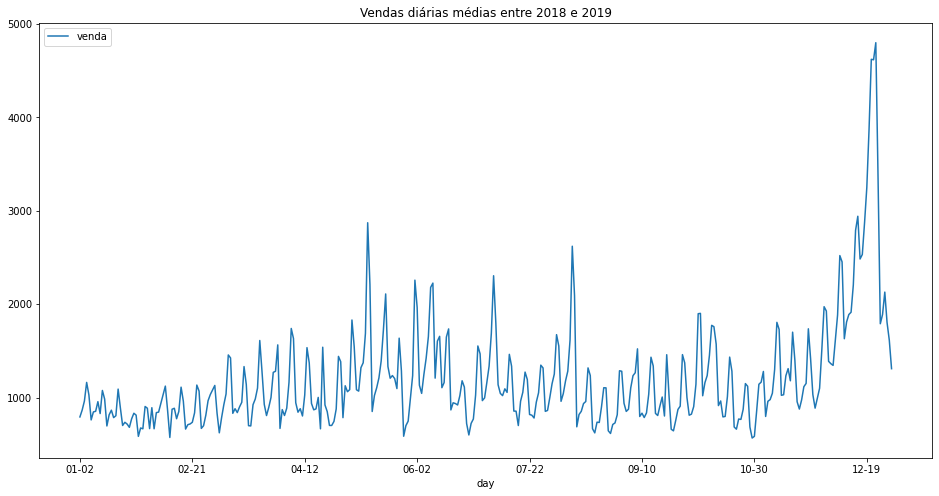

In [11]:
ds_days = ds.copy()
ds_days['day'] = ds_days.sales_day.map(lambda date: date[5:])
ds_days[ds.sales_day<'2020'].groupby('day').agg('mean').plot(figsize=(16,8),title = 'Vendas diárias médias entre 2018 e 2019');

As figuras acima também parecem indicar um componente cíclico semanal, que se confirma no gráfico de barras abaixo, com vendas médias por dia da semana. Observa-se um claro aumento ao longo da semana, com pico no sábado e queda no domingo.

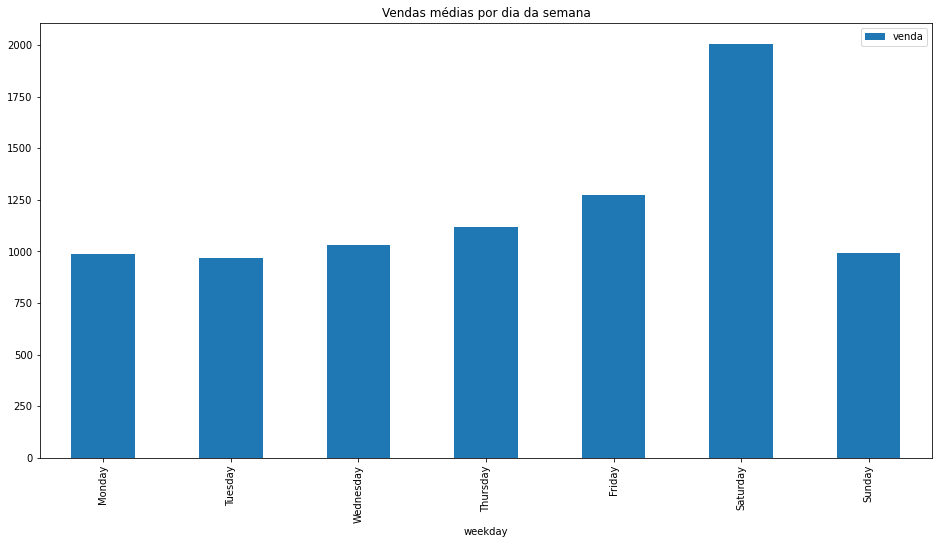

In [12]:
ds_weekdays = ds.copy()
ds_weekdays.index = pd.to_datetime(ds_weekdays.sales_day)
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

def get_weekday(string):
    year, month, day = string.split('-')
    date = datetime.date(int(year), int(month), int(day))
    return weekdays[date.weekday()]

ds_weekdays['weekday'] = ds_weekdays.sales_day.map(get_weekday)
ds_weekdays = ds_weekdays[ds_weekdays.sales_day<'2020']
ds_weekdays.groupby('weekday').agg('mean').sort_index(key = lambda days: [weekdays.index(day) for day in days]).plot.bar(figsize=(16,8), title='Vendas médias por dia da semana');

## 3.3 Criação do modelo

Nesta seção, faço a elaboração dos modelos utilizados. Como escolhi uma abordagem com modelo composto, criei separadamente o _encoder_, _decoder_ e o _predictor_, além do modelo _preprocess_. Estes modelos são então combinados utilizando o API funcional do _keras_.

A célula abaixo estabelece os hiperparâmetros usados na descrição, elaboração e treinamento do modelo.

In [13]:
BATCH_SIZE = 32
SEQUENCE_LENGTH = 30
PREDICTION_LENGTH = 3
INPUT_DIM = 1
ENCODING_DIM = 15
PREDICTOR_LOSS_WEIGHT = .20
EPOCHS = 1000
PATIENCE = 200
LEARNING_RATE = 1e-3
MIN_LEARNING_RATE = 1e-7
DECAY_STEPS = 200
NOISE_STD = .3
VERBOSE = 0
RNN_HIDDEN_UNITS = 256

Em seguida, uma instância da classe `Scaling` é criada, com modo `minmax`, correspondendo à aplicação de $log_{10}$ seguida por _scaling_ para o intervalo [-0.5,0.5]. Os _datasets_ de treinamento, validação e teste (2018, 2019 e 2020, respectivamente), são criados com estes parâmetros.

In [14]:
scaler = Scaling('minmax')
scaler.fit(ds.venda[ds.sales_day<'2019'])

ds_train = prepare_dataset(ds[ds.sales_day<'2019'], 'composite', SEQUENCE_LENGTH, BATCH_SIZE, PREDICTION_LENGTH, scaler)
ds_valid = prepare_dataset(ds[(ds.sales_day>='2019') & (ds.sales_day<'2020')], 'composite', SEQUENCE_LENGTH, BATCH_SIZE, PREDICTION_LENGTH, scaler)
ds_test = prepare_dataset(ds[ds.sales_day>='2020'], 'composite', SEQUENCE_LENGTH, BATCH_SIZE, PREDICTION_LENGTH, scaler)

O modelo que implementa o pré-processamento aplica uma camada _batch normalization_ (não só faz a normalização, mas permite ao modelo aprender a escala mais adequada para os dados) e uma camada de ruído gaussiano. 

O ruído serve como _data augmentation_ e também cumpre papel de regularização. Outras formas de regularização (como _dropout_ e _L2_) não tiveram impacto significativo na redução das métricas e foram removidas.

In [15]:
preprocess = Sequential(name='preprocess')
preprocess.add(InputLayer(input_shape=(SEQUENCE_LENGTH, INPUT_DIM), name='preprocess_input'))
preprocess.add(BatchNormalization(name='preprocess_batch_norm'))
preprocess.add(GaussianNoise(NOISE_STD, name='preprocess_noise'))
preprocess.compile()
preprocess.summary(line_length=120)

Model: "preprocess"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
preprocess_batch_norm (BatchNormalization)            (None, 30, 1)                                   4                 
________________________________________________________________________________________________________________________
preprocess_noise (GaussianNoise)                      (None, 30, 1)                                   0                 
Total params: 4
Trainable params: 2
Non-trainable params: 2
________________________________________________________________________________________________________________________


O _encoder_ é implementado com uma _stack_ de duas LSTMs. A primeira camada é bidirecional (possibilitado pelo fato de que alimenta a camada superior a cada passo). A camada seguinte não é bidirecional, já que a única saída utilizada é a final, que alimenta a camada densamente conectada que corresponde ao _encoding_.

In [16]:
encoder = Sequential(name='encoder')
encoder.add(InputLayer(input_shape=(SEQUENCE_LENGTH, INPUT_DIM), name='encoder_input'))
encoder.add(Bidirectional(LSTM(RNN_HIDDEN_UNITS, return_sequences=True), name='encoder_bi_lstm'))
encoder.add(LSTM(RNN_HIDDEN_UNITS, name='encoder_lstm'))
encoder.add(Dense(ENCODING_DIM, 'sigmoid', name='encoder_output'))
encoder.compile()
encoder.summary(line_length=120)

Model: "encoder"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
encoder_bi_lstm (Bidirectional)                       (None, 30, 512)                                 528384            
________________________________________________________________________________________________________________________
encoder_lstm (LSTM)                                   (None, 256)                                     787456            
________________________________________________________________________________________________________________________
encoder_output (Dense)                                (None, 15)                                      3855              
Total params: 1,319,695
Trainable params: 1,319,695
Non-trainable params: 0
____________________________________________________________

O _decoder_ é abastecido com o _encoding_, cujo vetor é repetido a cada passo e alimenta a primeira das duas camadas LSTM. Ambas as camadas são bidirecionais. Uma camada densamente conectada distribuída no tempo gera os valores decodificados a cada passo. Esta camada tem ativação _tanh_, que garante que os valores ficam no intervalo [-1,1], coerente com a transformação aplicada pelo `scaler`.

In [17]:
decoder = Sequential(name='decoder')
decoder.add(InputLayer(input_shape=(ENCODING_DIM), name='decoder_input'))
decoder.add(RepeatVector(SEQUENCE_LENGTH, name='decoder_repeat_encoding'))
decoder.add(Bidirectional(LSTM(RNN_HIDDEN_UNITS, return_sequences=True), name='decoder_bi_lstm_1'))
decoder.add(Bidirectional(LSTM(RNN_HIDDEN_UNITS, return_sequences=True), name='decoder_bi_lstm_2'))
decoder.add(TimeDistributed(Dense(1, 'tanh'), name='decoder_output'))
decoder.compile()
decoder.summary(line_length=120)

Model: "decoder"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
decoder_repeat_encoding (RepeatVector)                (None, 30, 15)                                  0                 
________________________________________________________________________________________________________________________
decoder_bi_lstm_1 (Bidirectional)                     (None, 30, 512)                                 557056            
________________________________________________________________________________________________________________________
decoder_bi_lstm_2 (Bidirectional)                     (None, 30, 512)                                 1574912           
________________________________________________________________________________________________________________________
decoder_output 

O _predictor_ tem exatamente a mesma arquitetura do _decoder_, com a exceção do cumprimento das sequências, que aqui é de apenas 3 observações (valor escolhido experimentalmente para minimizar a _loss function_ medida no _decoder_).

In [18]:
predictor = Sequential(name='predictor')
predictor.add(InputLayer(input_shape=(ENCODING_DIM), name='predictor_input'))
predictor.add(RepeatVector(PREDICTION_LENGTH, name='predictor_repeat_encoding'))
predictor.add(Bidirectional(LSTM(RNN_HIDDEN_UNITS, return_sequences=True), name='predictor_bi_lstm_1'))
predictor.add(Bidirectional(LSTM(RNN_HIDDEN_UNITS, return_sequences=True), name='predictor_bi_lstm_2'))
predictor.add(TimeDistributed(Dense(1, 'tanh'), name='predictor_output'))
predictor.compile()
predictor.summary(line_length=120)

Model: "predictor"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
predictor_repeat_encoding (RepeatVector)              (None, 3, 15)                                   0                 
________________________________________________________________________________________________________________________
predictor_bi_lstm_1 (Bidirectional)                   (None, 3, 512)                                  557056            
________________________________________________________________________________________________________________________
predictor_bi_lstm_2 (Bidirectional)                   (None, 3, 512)                                  1574912           
________________________________________________________________________________________________________________________
predictor_out

Finalmente, o modelo composto empilha uma camada de entrada, o pré-processamento e o _encoder_, então se divide no _decoder_ e no _predictor_. A arquitetura completa é mostrada na figura.

Model: "composite_model"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
composite_model_input (InputLayer)     [(None, 30, 1)]            0                                                     
________________________________________________________________________________________________________________________
preprocess (Sequential)                (None, 30, 1)              4             composite_model_input[0][0]             
________________________________________________________________________________________________________________________
encoder (Sequential)                   (None, 15)                 1319695       preprocess[0][0]                        
________________________________________________________________________________________________________________________
decoder

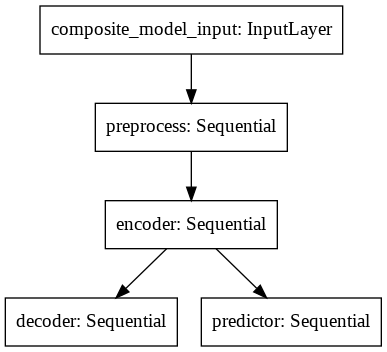

In [19]:
composite_model_input = Input(shape=(SEQUENCE_LENGTH, INPUT_DIM), name = 'composite_model_input')
preprocessed_input = preprocess(composite_model_input)
encoding = encoder(preprocessed_input)
reconstruction = decoder(encoding)
prediction = predictor(encoding)
composite_model = Model(name = 'composite_model',
                        inputs = composite_model_input,
                        outputs = [reconstruction, prediction])

composite_model.summary(line_length=120)
tf.keras.utils.plot_model(composite_model)
print('\n')

tf.keras.utils.plot_model(composite_model)

## 3.4 Treinamento do modelo

Aqui, o modelo completo é compilado e o treinamento é iniciado. Um fator multiplicativo (escolhido em 20% experimentalmente) é passado para o cálculo da _loss function_ composta pelas duas saídas.

São utilizados _callbacks_ de _early stopping_ e um _scheduler_ da taxa de aprendizado para otimizar a performance de treinamento.

A evolução das métricas ao longo do treinamento não está mostrada, para facilitar a leitura do _notebook_. Entretanto, a performance final é calculada e mostrada na célula a seguir e as curvas são apresentadas na próxima figura.

In [20]:
composite_model.compile(optimizer = Nadam(LEARNING_RATE),
                        loss = MeanSquaredError(),
                        loss_weights = [1, PREDICTOR_LOSS_WEIGHT])

callbacks = [EarlyStopping(patience = PATIENCE, restore_best_weights=True, monitor='val_decoder_loss'),
             LearningRateScheduler(lambda ep,lr: max(MIN_LEARNING_RATE, LEARNING_RATE / 10**(ep/DECAY_STEPS)))]

history = composite_model.fit(ds_train,
                              epochs = EPOCHS,
                              validation_data = ds_valid,
                              callbacks = callbacks,
                              verbose = VERBOSE)

print('Training performance (2018):')
composite_model.evaluate(ds_train);
print('Validation performance (2019):')
composite_model.evaluate(ds_valid);
print('Test performance (2020):')
composite_model.evaluate(ds_test);

Training performance (2018):
11/11 [==============================] - 0s 15ms/step - loss: 9.2356e-04 - decoder_loss: 6.8961e-04 - predictor_loss: 0.0012
Validation performance (2019):
11/11 [==============================] - 0s 15ms/step - loss: 0.0026 - decoder_loss: 0.0016 - predictor_loss: 0.0048
Test performance (2020):
6/6 [==============================] - 0s 14ms/step - loss: 0.0068 - decoder_loss: 0.0051 - predictor_loss: 0.0084


A figura abaixo mostra a evolução ao longo do treinamento das métricas total e obtidas nas duas tarefas separadamente. O fator multiplicativo reduzindo o peso da métrica do _predictor_ foi definido analisando os perfis destas curvas, de maneira a que ambas as métricas separadas tivessem perfil similar à metrica total. Considerei esse comportamento como sinal de não haver _overfitting_ desproporcional em nenhuma das duas tarefas.

Os perfis das curvas também corroboram a noção intuitiva de que a tarefa de predição é mais difícil do que a de decodificação do sinal de entrada (ao menos com esta combinação de ruído, dimensionalidade do _encoding_, cumprimento da sequência prevista e demais hiperparâmetros).

A análise destas curvas sucessivamente para diversas combinações de hiperparâmetros também mostrou a vantagem do princípio de _multitask learning_: ao usar o peso muito baixo para a tarefa de reconstrução (virtualmente a eliminando do cálculo da _loss function_ composta), a métrica para o _decoder_ evoluiu mais lentamente, mostrando que a tarefa secundária ajudou na velocidade de convergência. O valor final da _loss function_ no _decoder_ também foi sutilmente melhorado através do treinamento do modelo combinado.

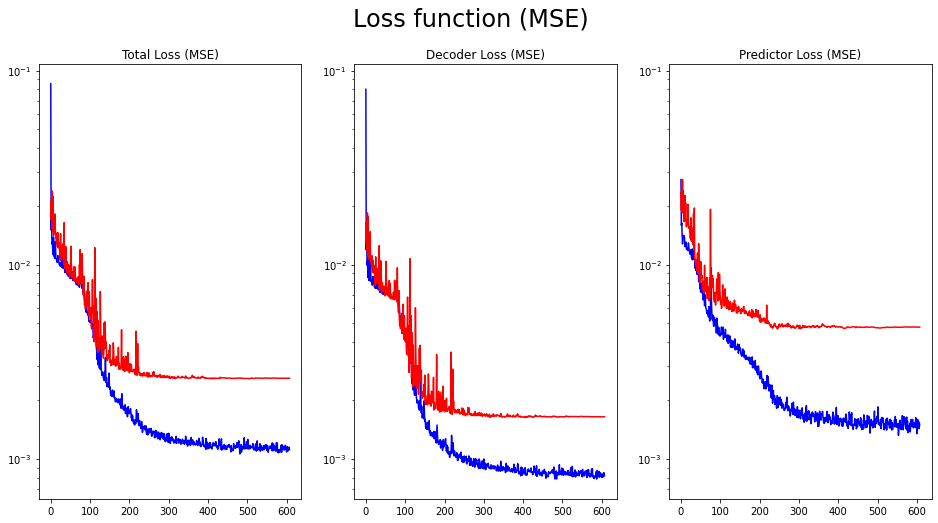

In [21]:
plt.figure(figsize = (16,8))
plt.suptitle('Loss function (MSE)', fontsize=24)
ax = plt.subplot(1,3,1)
plt.title('Total Loss (MSE)')
plt.semilogy(history.history['loss'], 'b');
plt.semilogy(history.history['val_loss'], 'r');
plt.subplot(1,3,2, sharey=ax)
plt.title('Decoder Loss (MSE)')
plt.semilogy(history.history['decoder_loss'], 'b');
plt.semilogy(history.history['val_decoder_loss'], 'r')
plt.subplot(1,3,3, sharey=ax)
plt.title('Predictor Loss (MSE)')
plt.semilogy(history.history['predictor_loss'], 'b')
plt.semilogy(history.history['val_predictor_loss'], 'r')
plt.show()

# 4 Resultados

A figura a seguir mostra exemplos dos resultados obtidos no conjunto de treinamento (2018), validação (2019) e testes (2020). As linhas azuis mostram a sequência original, enquanto as linhas vermelhas mostram a sequência reconstruída (até a linha vertical) e projetada (após a linha vertical).

Uma inspeção visual das curvas mostra que, nos anos de 2018 e 2019, o modelo foi capaz de reconstruir aproximações fiéis da sequência de entrada, capturando _features_ como o comportamento semanal das sequências. Mesmo no período projetado, que não foi capturado nos dados de entrada, a extrapolação consegue representar os picos e vales esperados.

Entretanto, percebe-se que os resultados para o ano de 2020 são bem menos precisos que para os anteriores. Ao longo deste ano, os dados cobrem uma região do espaço de parâmetros não explorada no treinamento do modelo, ficando longe da _manifold_ coberta pelos dados de treinamento e validação.

Percebe-se que, mesmo em períodos com vendas quase nulas, o modelo continua prevendo comportamento cíclico semanal. Isso reflete o fato de que a arquitetura do _autoencoder_ depende fortemente do compartilhamento de premissas sobre a natureza dos dados entre o _encoder_ e o _decoder_. Não existe real compactação dos dados: a redução de dimensionalidade advém do fato de que parte da informação é __removida__, com o entendimento de que é válida para todos os exemplos e não precisa ser contida no vetor de _encoding_.

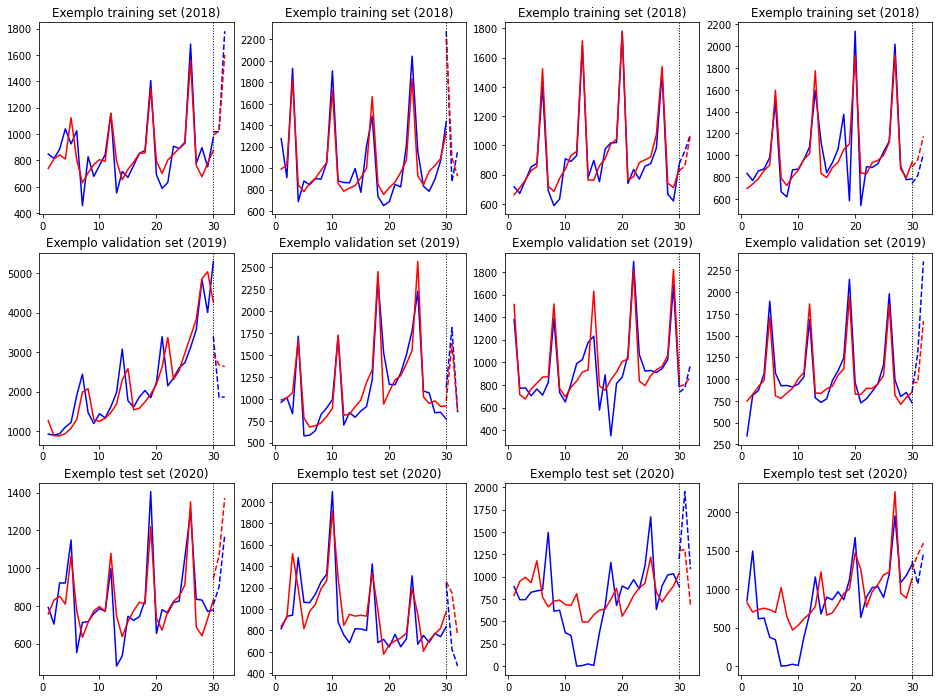

In [22]:
# definição de x, yr e yp para o training set
sample = ds_train.take(1).as_numpy_iterator().next()
x, y = sample
yr, yp = y

# definição de x, yr e yp para o validation set
sample = ds_valid.take(1).as_numpy_iterator().next()
x_val, y_val = sample
yr_val, yp_val = y_val

# definição de x, yr e yp para o test set
sample = ds_test.take(1).as_numpy_iterator().next()
x_test, y_test = sample
yr_test, yp_test = y_test

# definição do yr_hat e yp_hat para as três partições
yr_hat, yp_hat = composite_model.predict(x)
yr_hat_val, yp_hat_val = composite_model.predict(x_val)
yr_hat_test, yp_hat_test = composite_model.predict(x_test)

# plot de figuras com exemplos das 3 partições
plt.figure(figsize=(16,12))

# exemplos 2018
for p in range(1,5):
    plt.subplot(3,4,p)
    plt.title(f'Exemplo training set (2018)')
    plt.plot(range(SEQUENCE_LENGTH,0,-1), scaler.inverse_transform(yr[p, :, :]), 'b');
    plt.plot(range(SEQUENCE_LENGTH,0,-1), scaler.inverse_transform(yr_hat[p, :, :]), 'r');
    plt.plot(range(SEQUENCE_LENGTH,SEQUENCE_LENGTH+PREDICTION_LENGTH), scaler.inverse_transform(yp[p, :, :]), 'b--');
    plt.plot(range(SEQUENCE_LENGTH,SEQUENCE_LENGTH+PREDICTION_LENGTH), scaler.inverse_transform(yp_hat[p, :, :]), 'r--');
    plt.axvline(SEQUENCE_LENGTH, c = 'black',linestyle=':', linewidth=1, alpha=1);

# exemplos 2019
for p in range(5,9):
    plt.subplot(3,4,p)
    plt.title(f'Exemplo validation set (2019)')
    plt.plot(range(SEQUENCE_LENGTH,0,-1), scaler.inverse_transform(yr_val[p, :, :]), 'b');
    plt.plot(range(SEQUENCE_LENGTH,0,-1), scaler.inverse_transform(yr_hat_val[p, :, :]), 'r');
    plt.plot(range(SEQUENCE_LENGTH,SEQUENCE_LENGTH+PREDICTION_LENGTH), scaler.inverse_transform(yp_val[p, :, :]), 'b--');
    plt.plot(range(SEQUENCE_LENGTH,SEQUENCE_LENGTH+PREDICTION_LENGTH), scaler.inverse_transform(yp_hat_val[p, :, :]), 'r--');
    plt.axvline(SEQUENCE_LENGTH, c = 'black',linestyle=':', linewidth=1, alpha=1);

# exemplos 2020
for p in range(9,13):
    plt.subplot(3,4,p)
    plt.title(f'Exemplo test set (2020)')
    plt.plot(range(SEQUENCE_LENGTH,0,-1), scaler.inverse_transform(yr_test[p, :, :]), 'b');
    plt.plot(range(SEQUENCE_LENGTH,0,-1), scaler.inverse_transform(yr_hat_test[p, :, :]), 'r');
    plt.plot(range(SEQUENCE_LENGTH,SEQUENCE_LENGTH+PREDICTION_LENGTH), scaler.inverse_transform(yp_test[p, :, :]), 'b--');
    plt.plot(range(SEQUENCE_LENGTH,SEQUENCE_LENGTH+PREDICTION_LENGTH), scaler.inverse_transform(yp_hat_test[p, :, :]), 'r--');
    plt.axvline(SEQUENCE_LENGTH, c = 'black',linestyle=':', linewidth=1, alpha=1);

A seguir, analisamos todas as amostras do conjunto original, junto com a evolução ao longo do tempo do erro de reconstrução pelo _autoencoder_. O erro está calculado nos valores com aplicação de $log_{10}$ e _scaling_, portanto não guardam relação direta intuitiva com o erro na escala original.

Alguns artefatos chamam a atenção. Em primeiro lugar, o erro é calculado ao fim de cada período de 30 dias, o que torna seu perfil atrasado em relação ao período que está representando. Assim, para usar o erro de reconstrução como indicador de que os dados estão fugindo de um padrão esperado, é importante que o período escolhido seja compatível com a expectativa de tempo de resposta.

Além disso, observa-se que o erro é consideravalmente mais elevado ao redor dos períodos de Natal dos anos de 2018 e 2019. Este comportamento não é surpreendente, já que os perfis de vendas ao longo do mês de dezembro são muito diferentes do restante do ano. O efeito também é observado em menor escala por volta dos meses de maio e junho de 2019 (que correspondem ao dia dos namorados e dia das mães).

Este desvio poderia ser mitigado ao incluir dados adicionais na entrada do _encoder_. Por exemplo, uma representação categórica indicando o mês do ano (informação já presente no _dataset_ original) permitiria que o modelo aprendesse que alguns meses tem comportamentos bastante específicos. Experimentei com este conceito na modelagem, porém os dados estão fornecidos em volume muito baixo para que a rede neural pudesse capturar o padrão. Acredito que, com um _dataset_ contendo dados ao longo de diversos anos ou de uma quantidade maior de lojas, seria possível que o modelo aprendesse a capturar este aspecto sazonal no _encoding_.

Por último, observa-se um aumento sensível do erro de reconstrução à partir de março de 2020. Neste período, a política de _lockdown_ abaixou em alguns ordens de grandeza o nível de vendas, o que foi refletido na capacidade do modelo de representar os dados.

Este comportamento reforça o potencial de aplicação de arquiteturas de _autoencoders_ para identificação de anomalias. Um modelo desta natureza poderia facilmente ser aplicado às vendas totais, à cada uma das lojas da cadeia ou até mesmo classes de produtos. Um aumento não-explicado do nível de erro de reconstrução poderia indicar a necessidade de investigação mais à fundo sobre o tipo de fenômeno causador do desvio, e ações podem ser implementadas para melhor aproveitar oportunidades ou mitigar problemas.

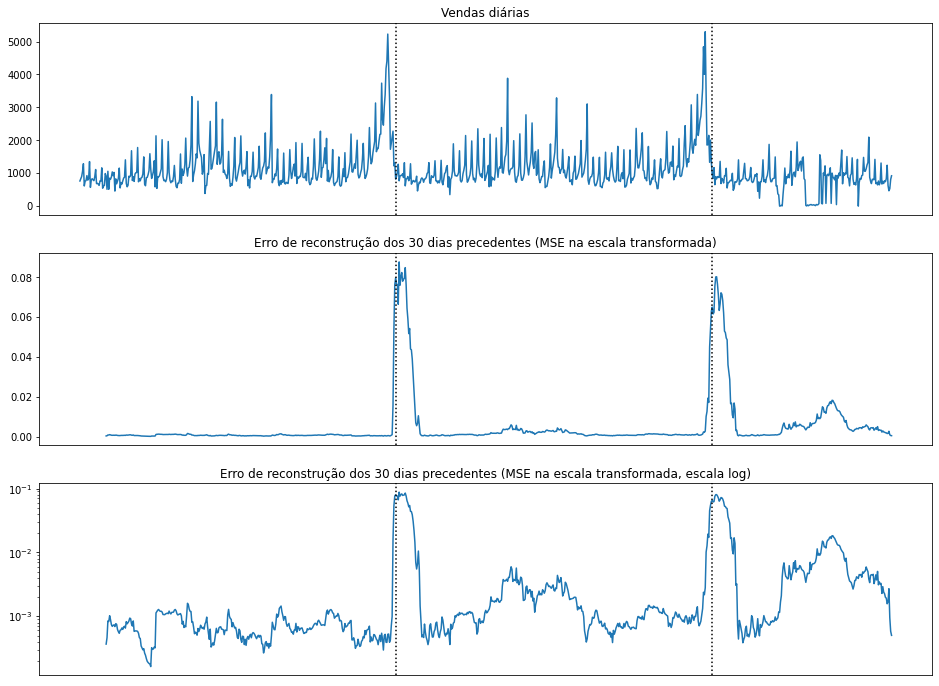

In [23]:
# obtenção das sequências originais e reconstruídas
vendas = ds.venda.values
x = np.array([scaler.transform(vendas[start:start+30]) for start in range(len(vendas)-30)])
y_hat, _ = composite_model.predict(x)
y_hat = np.squeeze(y_hat)
y_hat = y_hat[:,::-1]

# cálculo do MSE da reconstrução do sinal ao fim de cada período
mse_fn = MeanSquaredError()
mse = np.array([mse_fn(x[step,:], y_hat[step,:]) for step in range(x.shape[0])])
index_2019 = ds[ds.sales_day < '2019'].shape[0]
index_2020 = ds[ds.sales_day < '2020'].shape[0]

# plot dos níveis de venda
plt.figure(figsize=(16,12))
ax = plt.subplot(3,1,1)
plt.title('Vendas diárias')
plt.plot(vendas);
plt.axvline(index_2019, c='black', linestyle=':');
plt.axvline(index_2020, c='black', linestyle=':');
plt.xticks([]);

# plot do MSE
plt.subplot(3,1,2, sharex=ax)
plt.title('Erro de reconstrução dos 30 dias precedentes (MSE na escala transformada)')
plt.plot(np.arange(SEQUENCE_LENGTH, SEQUENCE_LENGTH+mse.shape[0]), mse);
plt.axvline(index_2019, c='black', linestyle=':');
plt.axvline(index_2020, c='black', linestyle=':');
plt.xticks([]);

# plot do MSE em escala semilogy
plt.subplot(3,1,3, sharex=ax)
plt.title('Erro de reconstrução dos 30 dias precedentes (MSE na escala transformada, escala log)')
plt.semilogy(np.arange(SEQUENCE_LENGTH, SEQUENCE_LENGTH+mse.shape[0]), mse);
plt.axvline(index_2019, c='black', linestyle=':');
plt.axvline(index_2020, c='black', linestyle=':');
plt.xticks([]);

# 5 Conclusão

Neste _notebook_, elaborei um modelo de _autoencoder_ baseado em _stacks_ de LSTMs com treinamento _multitasking_, seguindo os princípios do modelo combinado apresentado na seção 2.4 do _paper_ de referência [Unsupervised Learning of Video Representations using LSTMs](http://www.cs.toronto.edu/~nitish/unsup_video.pdf).

O modelo foi treinado com os dados de venda ao longo do ano de 2018 e apresentou resultados precisos (sob análise visual) para reconstrução de sequências durante 2019. Entretanto, observou-se um aumento considerável no erro de reconstrução no mês de dezembro, indicando que não houver dados suficientes para identificação dos diferentes padrões de consumo durante o Natal.

Observou-se também um aumento do erro de reconstrução à partir de meados de março de 2020, mês que em que os padrões de vendas foram drasticamente afetados por sucessivos períodos de _lockdown_. Este resultado corrobora a capacidade que arquiteturas de _autoencoder_ têm para identificiar anomalias nos dados.

Como principal potencial de melhoria da aplicação, recomendaria o uso de um volume maior de dados para treinamento (seja através de período mais longo ou um número maior de lojas), uso de pré-treinamento com outros _datasets_ de sequência temporal, inclusão de informações adicionais do _dataset_ no vetor de entrada do _encoder_ e _tuning_ dos hiperparâmetros através de busca aleatória sistemática com ferramenta como o _keras tuner_.

Por fim, recomenda-se que, após o desenvolvimento e _tuning_ de hiperparâmetros, o modelo seja retreinado com os dados das partições de treinamento e validação.